# Практическое задание к уроку 8. Снижение размерности данных

### 1. Можно ли отобрать наиболее значимые признаки с помощью PCA?

Метод главных компонент (PCA) заключается в приближении матрицы признаков матрицей меньшего ранга - так называемом низкоранговом приближении. При данном мпетоде формируются новые признаки и отобрать наиболее значимые из признаков представленных в датасете нельзя

### 2*. Примите участие в одном или двух соревнованиях и пришлите свой псевдоним на Kaggle и ссылку на github с решением соревнования

Псевдоним Kaggle Dmitry


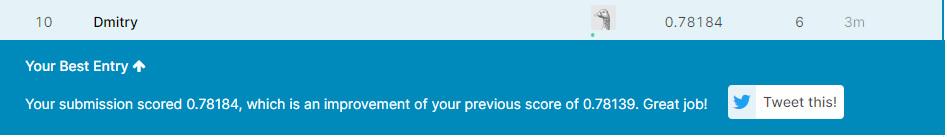

ССылка GitHub https://github.com/deim76/Algoritm/blob/master/CourseProject_It.ipynb

### 3*. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [3]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [4]:
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [5]:
# Масштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [43]:
U, s, W = np.linalg.svd(X_)

#Транспонируем матрицу W
V = W.T

# s - список диагональных элементов, его нужно привести к виду диагональной матрицы для наглядности
D = np.zeros_like(X_, dtype=float)
D[np.diag_indices(2)] = s[:2]
print(s)

[20.92306556 11.7091661   4.69185798  1.76273239]


In [44]:
# выберем первые 2
D[np.diag_indices(len(s[:2]))] = s[:2]

In [45]:
# Сформируем новую матрицу "объекты-признаки"
Z = np.dot(np.dot(U, D), V.T)

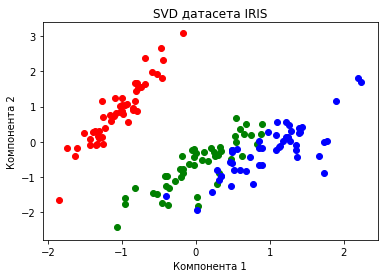

In [47]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Компонента 1')
plt.ylabel('Компонента 2')
plt.title('SVD датасета IRIS')
plt.show()

### 4*. Обучить любую модель классификации на датасете iris до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [54]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# класс листа
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)# Разбиение датасета в узле

# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels 

# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)



def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

# функция формирования предсказания по выборке на одном дереве


def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
  
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions    

In [58]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [55]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, test_size=0.25)

In [57]:
model=random_forest(X_train, y_train, 10)

In [60]:
test_answers = tree_vote(model, X_test)

In [61]:
accuracy_metric(y_test, test_answers)

94.73684210526315

In [62]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [63]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по строке
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]

In [64]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
437.7746724797993
137.10457072021043
22.013531335697234
3.1072254642928705


In [71]:
# Сформируем вектор весов из собственных векторов, соответствующих первым 2 главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [77]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[72.96244541329989, 22.850761786701742, 3.668921889282873, 0.5178709107154785]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


In [72]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_.dot(W)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(Z, y,shuffle=True, test_size=0.25)

In [74]:
model=random_forest(X_train, y_train, 10)

In [75]:
test_answers = tree_vote(model, X_test)

In [76]:
accuracy_metric(y_test, test_answers)

84.21052631578947

Точность модели до применения метода PCA 94.7368
После применения 84.21052631578947 это объясняется тем что взято только 2 признака из 4 с общей долей дисперсии 95.8132
Если взять 3 компоненты точность модели =  94.7368 одинаково что и без применимя метода РСА хотя в данном случаи перешли от 4 мерного к тремерному пространству признаков